##**CIS 519 - Final Submission**

##***Cyber Forensics - Deep Fake Detection using Transfer Learning Based CNN Framework***

####Members:
* Ankit Singh Tevathiya
* Bushra Kidwai
* Ishani Mhatre




# Setup and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install face_recognition 
!pip install timm
!sudo pip install git+https://github.com/okankop/vidaug

     |████████████████████████████████| 100.1 MB 23 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=cb48370ab3678025941d11266b29f8d47b4ed8ddb0e9bcfad452d3434c151cd1
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models
     |████████████████████████████████| 431 kB 4.2 MB/s 
  Cloning https://github.com/okankop/vidaug to /tmp/pip-req-build-duo30fk3
  Running command git clone -q https://github.com/okankop/vidaug /tmp/pip-req-build-duo30fk3
  Created wheel for vidaug: filename=vidaug-0.1-py3-none-any.whl size=13034 sha256=5921fed0bba63a8ac41fd34e7fadff89fbff0a6d9fe0361c7f6a4f3274dc15ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-dl4z_25s/wheels/9b/d4/8e/257b7d79ad86dbaae5deb117aac58db00c60e697bec84b7c54
Successfully built vidaug


In [ ]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import face_recognition 
import json
import copy
import random
import timm
from torch import nn
import torch.nn.functional as F
from torchvision import models
from torch.autograd import Variable
import time
import sys
import seaborn as sn
from sklearn.metrics import confusion_matrix
from skimage.color import rgb2gray
%matplotlib inline
from scipy import ndimage
import math
import skimage.io
import matplotlib
from sklearn.model_selection import train_test_split

# Exploratory Analysis

In [ ]:
#read file
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
video_fil =  glob.glob('/content/drive/My Drive/lost/train_sample_videos/*.mp4')
print(len(video_fil))

400


In [ ]:
def frame_extraction(path):
  vid = cv2.VideoCapture(path) 
  s = 1
  while s:
      s, im = vid.read()
      if s:
          yield im

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)]) 

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

In [ ]:
def video_validation(path, train_transforms):
      count = 20
      video_path = path
      frames = []
      a = int(100/count) 
      first_frame = np.random.randint(0,a)
      temp_video = video_path.split('/')[-1]
      transform = train_transforms
      for i,frame in enumerate(frame_extraction(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):
          break
      frames = torch.stack(frames)
      frames = frames[:count]
      return frames


# print("Total no of videos :" , len(video_fil))
# print(video_fil)
count = 0;
for i in video_fil:
  try:
    count+=1
    video_validation(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_fil) - count))
    print("Corrupted video is : " , i)
    continue
print((len(video_fil) - count)) 

0


In [ ]:
video_files =  glob.glob('/content/drive/My Drive/lost/train_sample_videos/*.mp4')


random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
# print("frames are " , frame_count)
# print("Total no of video: " , len(frame_count))
# print('Average frame per video:',np.mean(frame_count)) 

In [ ]:
# load the video name and labels from csv

class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/lost/train_sample_videos/metadata2.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

# Augmentation

In [ ]:
train_sample_metadata = pd.read_json('/content/drive/My Drive/lost/train_sample_videos/metadata.json').T

train_sample_metadata.head()


,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [ ]:
#code to capture frames of each video

VIDEO_STREAM = "/content/drive/My Drive/lost/test_videos/ytddugrwph.mp4"


frames_array = []

vidcap = cv2.VideoCapture(VIDEO_STREAM)
def getFrame(sec):
   
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*10000)
    hasFrames, image = vidcap.read()
    if hasFrames:
        cv2.imwrite("image"+str(count)+".jpg", image) # save frame as JPG file
        frames_array.append(image)
    return frames_array, hasFrames

sec = 0
frameRate = 0.1 #//it will capture image in each 0.5 second
count=1
success=True

while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    im_array ,success = getFrame(sec)
   

In [ ]:
from PIL import Image
from matplotlib import cm

pil_im = []
for i in range(0, len(im_array)):
  im = Image.fromarray(im_array[i],'RGB')
  pil_im.append(im)
  print(im)

<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7FA083A06C90>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299410>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F5A3544D0>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299C10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299E90>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299F10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57299D10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F57287390>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F5A2CADD0>


In [ ]:
#code to apply ensemble of different augmentation techniques on each frame
from vidaug import augmentors as va

sometimes = lambda aug: va.Sometimes(0.5, aug) # Used to apply augmentor with 50% probability
seq = va.Sequential([
    # va.RandomCrop(size=(240, 180)), # randomly crop video with a size of (240 x 180)
    va.RandomRotate(degrees=30), # randomly rotates the video with a degree randomly choosen from [-10, 10]  
    sometimes(va.VerticalFlip()), # horizontally flip the video with 50% probability
    sometimes(va.InvertColor())
])
video_aug = seq(pil_im)
print(video_aug)

[<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F572A1A10>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B73D0>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7450>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B74D0>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7550>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7610>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7690>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7710>, <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7790>]


In [ ]:
for i in range(len(video_aug)):
  print(video_aug[i])

<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F572A1A10>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B73D0>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7450>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B74D0>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7550>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7610>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7690>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7710>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F9F4F2B7790>


# Data Loader

Number of videos in train set:  320
Number of videos in test set:  80
Train set analysis :  
Real videos :  61 , Fake videos :  259
Test set analysis :  
Real videos :  16 , Fake videos :  64


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


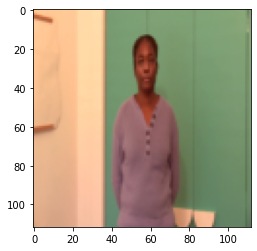

In [ ]:
# load the labels and video in data loader

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/lost/train_sample_videos/metadata2.csv',names=header_list)

train_set = video_files[:int(0.8*len(video_files))]
valid_set = video_files[int(0.8*len(video_files)):]
print("Number of videos in train set: " , len(train_set))
print("Number of videos in test set: " , len(valid_set))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)

print("Train set analysis : ", "\nReal videos : ",number_of_real_and_fake_videos(train_set)[0],", Fake videos : ",number_of_real_and_fake_videos(train_set)[1])
print("Test set analysis : ", "\nReal videos : ",number_of_real_and_fake_videos(valid_set)[0],", Fake videos : ",number_of_real_and_fake_videos(valid_set)[1])

train_data = video_dataset(train_set,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_set,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

# Auxiliary functions

In [ ]:
# function to calculate Accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def calculate_accuracy(outputs, targets):
    _, prediction = outputs.topk(1, 1, True)
    prediction = prediction.t()
    correct = prediction.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / targets.size(0)

# Plot functions

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):

    confusn_matrix = confusion_matrix(y_true, y_pred)
    TP = confusn_matrix[0][0]
    FN = confusn_matrix[1][0]
    FP = confusn_matrix[0][1]
    TN = confusn_matrix[1][1]
    # print('True positive = ', TP)
    # print('False negative = ', FN)
    # print('False positive = ', FP)
    # print('True negative = ', TN, '\n')

    df_confusn_matrix = pd.DataFrame(confusn_matrix, range(2), range(2))
    sn.set(font_scale = 1.35) # for label size
    sn.heatmap(df_confusn_matrix, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 14)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 14)
    plt.ylim([2, 0])
    plt.show()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    print("Accuracy : ", accuracy*100, "%")
    precision = TP / (TP + FP)
    recall = TP / (TP + TN)
    f1_score = (2 * precision * recall) / (precision + recall)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1_score)


In [ ]:
#function to plot loss
def plot_loss(train_loss,test_loss, epochs):
  loss_train = train_loss
  loss_val = test_loss
  print(epochs)
  epochs = range(1, num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def plot_accuracy(train_accuracy, test_accuracy, n_epochs):
  train_acc = train_accuracy
  val_acc = test_accuracy
  epochs = range(1, n_epochs + 1)
  plt.plot(epochs, train_acc, 'g', label= 'Training accuracy')
  plt.plot(epochs, val_acc, 'b', label= 'validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# Models

## 1. Baseline Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        '''
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        '''

        self.conv1 = nn.Conv2d(3,32, kernel_size=(3, 3))
        #self.conv2 = nn.Conv2d(32,32, kernel_size=(3, 3))
        self.max1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(32,64, kernel_size=(3, 3))
        #self.conv4 = nn.Conv2d(64,64, kernel_size=(3, 3))
        self.max2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv5 = nn.Conv2d(64,128, kernel_size=(3, 3))
        #self.conv6 = nn.Conv2d(128,128, kernel_size=(3, 3))
        self.max3 = nn.MaxPool2d(kernel_size=(2, 2))
        #Flatten(),

        # 2x dense layers to learn from features extracted from convolutions
        self.l1 = nn.Linear(18432,64)
        self.l2 = nn.Linear(64,2)
        # output layer of 1 neuron with sigmoid activation for binary classification
        #self.l3 = nn.Linear(32,2) 

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.35)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
                
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x=self.batch_norm1(x)
        x=self.dropout1(x)
        #print(x.shape)
        #x = F.relu(self.conv2(x))
        #print(x.shape)
        x = self.max1(x)
        #print("max",x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        #x = F.relu(self.conv4(x))
        #print(x.shape)
        x=self.batch_norm2(x)
        x=self.dropout2(x)
        x = self.max2(x)
        #print(x.shape)
        x = F.relu(self.conv5(x))
        #print(x.shape)
        #x = F.relu(self.conv6(x))
        #print(x.shape)
        x = self.max3(x)
        #print(x.shape[0])
        
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.l1(x))
        #print(x.shape)
        x = F.relu(self.l2(x))
        #print(x.shape)
        # x = self.l3(x)
        output = F.softmax(x, dim=1)
        #print(x.shape)

        #fmap = self.model(x)
        #x = self.avgpool(fmap)
        #x = x.view(batch_size,seq_length,2048)
        #x_lstm,_ = self.lstm(x,None)
        #return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))
        return output


In [ ]:
model = Model().cuda()
a = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    print("inside train_epoch")
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    true = []
    pred = []
    for i, (inputs, targets) in enumerate(data_loader):
       
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        
        bs,seq_length, c, h, w = inputs.shape
        #print(batch_size,seq_length, c, h, w)
        outputs = model(inputs)
        results = torch.zeros((bs,2)).cuda()
        c = 0 # c = -1
        #inflated_targets = torch.zeros(bs*seq_length).cuda()
        
        for j in range(0,bs*seq_length,10):
          
          #print(outputs[i:i+10],len(outputs[i:i+10]))
          results[c] = torch.mean(outputs[j:j+10],dim=0)
          c = c+1 
        #   #print(results)

        # for j in range(bs*seq_length):
        #   if j % seq_length == 0:
        #     c += 1

        #   inflated_targets[j] = targets[c]

        #results = results.view(1,-1) 
        #print(results.shape,targets.shape)
      
        loss  = criterion(results,targets.type(torch.cuda.LongTensor))
        #loss = criterion(outputs, inflated_targets.type(torch.cuda.LongTensor))
        
        acc = calculate_accuracy(results, targets.type(torch.cuda.LongTensor))
        #acc = calculate_accuracy(outputs, inflated_targets.type(torch.cuda.LongTensor))
        _,p = torch.max(outputs,1)
        true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
        pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write( 
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return true, pred, losses.avg, accuracies.avg

def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            outputs = model(inputs)

            batch_size,seq_length, c, h, w = inputs.shape
            #print(batch_size,seq_length, c, h, w)
            outputs = model(inputs)
            results = torch.zeros((batch_size,2)).cuda()
            c = 0 # c = -1

            #inflated_targets = torch.zeros(batch_size*seq_length).cuda()

            for j in range(0,batch_size*seq_length,10):
              results[c] = torch.mean(outputs[j:j+10],dim=0)
              c = c+1

            # for j in range(batch_size*seq_length):
            #   if j % seq_length == 0:
            #     c += 1

            #     inflated_targets[j] = targets[c]
            
            #print(results)
            #outputs = torch.mean(outputs,dim=1).view(1,-1)

            loss = torch.mean(criterion(results, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(results,targets.type(torch.cuda.LongTensor))
            #loss = criterion(outputs, inflated_targets.type(torch.cuda.LongTensor))
            #acc = calculate_accuracy(outputs, inflated_targets.type(torch.cuda.LongTensor))

            # _,p = torch.max(results,1)
            _,p = torch.max(outputs,1)  
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            #true += (inflated_targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(inflated_targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
#learning rate
lr = 0.005
#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss =[]
train_acc = []
test_loss = []
test_acc = []
for epoch in range(1,num_epochs+1):
    true1, pred1, loss1, acc1 = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss.append(loss1)
    train_acc.append(acc1)
    true2, pred2, loss2, acc2 = test(epoch,model,valid_loader,criterion)
    test_loss.append(loss2)
    test_acc.append(acc2)


inside train_epoch
[Epoch 1/10] [Batch 79 / 80] [Loss: 0.802159, Acc: 51.51%]
Testing
[Batch 19 / 20]  [Loss: 0.835223, Acc: 47.51%]
Accuracy  47.5
inside train_epoch
[Epoch 2/10] [Batch 79 / 80] [Loss: 0.803493, Acc: 51.02%]
Testing
[Batch 19 / 20]  [Loss: 0.835223, Acc: 47.51%]
Accuracy  47.5
inside train_epoch
[Epoch 3/10] [Batch 79 / 80] [Loss: 0.803493, Acc: 51.02%]
Testing
[Batch 19 / 20]  [Loss: 0.835223, Acc: 47.51%]
Accuracy  47.5
inside train_epoch
[Epoch 4/10] [Batch 79 / 80] [Loss: 0.803493, Acc: 51.02%]
Testing
[Batch 19 / 20]  [Loss: 0.835223, Acc: 47.51%]
Accuracy  47.5
inside train_epoch
[Epoch 5/10] [Batch 79 / 80] [Loss: 0.803493, Acc: 51.02%]
Testing
[Batch 19 / 20]  [Loss: 0.835223, Acc: 47.51%]
Accuracy  47.5
inside train_epoch
[Epoch 6/10] [Batch 79 / 80] [Loss: 0.803493, Acc: 51.02%]
Testing
[Batch 19 / 20]  [Loss: 0.835223, Acc: 47.51%]
Accuracy  47.5
inside train_epoch
[Epoch 7/10] [Batch 79 / 80] [Loss: 0.803493, Acc: 51.02%]
Testing
[Batch 19 / 20]  [Loss: 0.

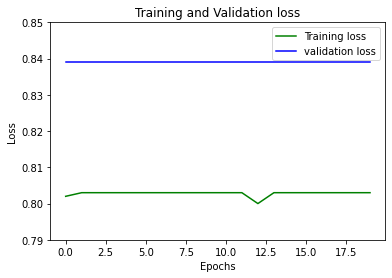

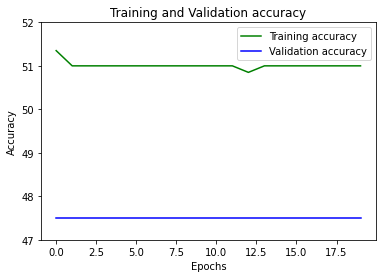

In [ ]:
plot_loss(train_loss, test_loss, len(train_loss))
plot_accuracy(train_acc, test_acc,len(train_acc))

In this graph we see that loss and accuracy plots are quite static which points towards the fact the model is not learning. This stems from the fact that CNN is unable to correalte information between multiple frames. Even though CNN can work well in feature extraction, the absence of capability to capture temporal behviour leads to flat-line curves. Since our dataset is imbalanced it just keeps predicting "Fake" as this tag is higher in number.

TRAIN:


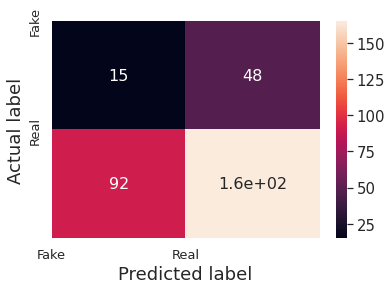

Accuracy:  56.25 %
Precision:  0.23809523809523808
Recall:  0.08333333333333333
F1 score:  0.1234567901234568


TEST:


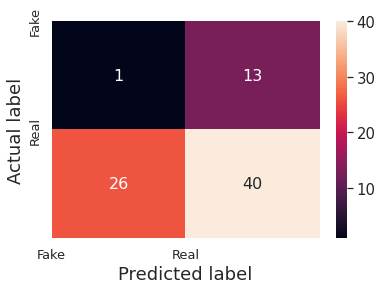

Accuracy:  51.24999999999999 %
Precision:  0.07142857142857142
Recall:  0.024390243902439025
F1 score:  0.03636363636363637


In [ ]:
print("TRAIN:")
print_confusion_matrix(true1, pred1)
print("\n\nTEST:")
print_confusion_matrix(true2, pred2)

## 2. Inception Net

In [ ]:
from torchvision import models

In [ ]:
class Inception_Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Inception_Model, self).__init__()
        model = models.inception(pretrained=True)
        # model = timm.create_model('inception_v3', pretrained=True)

        self.model = nn.Sequential(*list(model.children())[:-2])
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(2048,256)
        self.fc2 = nn.Linear(256,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        
    def forward(self, t):
        batch_size,seq_length, c, h, w = t.shape 
        t = t.view(batch_size * seq_length, c, h, w)
        forw = self.model(t)
        t = self.avgpool(forw)
        t = t.view(batch_size,seq_length,2048)
        t_lstm, _ = self.lstm(t, None)
        t = self.dropout(self.relu(self.fc1(torch.mean(t_lstm, dim = 1))))
        t = self.fc2(t)
        return forw, t

In [ ]:
model2 = Inception_Model(2).cuda()

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model2.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    true = []
    pred = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _, outputs = model2(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        _,p = torch.max(outputs,1)
        true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
        pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return true, pred, losses.avg, accuracies.avg

def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model2.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model2(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg


In [ ]:
num_epochs = 10
lr = 0.05

optimizer = torch.optim.Adam(model2.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()

train_loss =[]
train_acc = []
test_loss = []
test_acc = []
for epoch in range(1,num_epochs+1):
    true1, pred1, loss1, acc1 = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss.append(loss1)
    train_acc.append(acc1)
    true2, pred2, loss2, acc2 = test(epoch,model,valid_loader,criterion)
    test_loss.append(loss2)
    test_acc.append(acc2)
  

inside train_epoch
[Epoch 1/10] [Batch 79 / 80] [Loss: 0.831245, Acc: 49.03%]
Testing
[Batch 19 / 20]  [Loss: 0.901934, Acc: 50.92%]
Accuracy  50.92
inside train_epoch
[Epoch 2/10] [Batch 79 / 80] [Loss: 0.792352, Acc: 49.99%]
Testing
[Batch 19 / 20]  [Loss: 0.832495, Acc: 52.02%]
Accuracy  52.01
inside train_epoch
[Epoch 3/10] [Batch 79 / 80] [Loss: 0.782318, Acc: 51.91%]
Testing
[Batch 19 / 20]  [Loss: 0.811932, Acc: 51.91%]
Accuracy  51.91
inside train_epoch
[Epoch 4/10] [Batch 79 / 80] [Loss: 0.751264, Acc: 53.12%]
Testing
[Batch 19 / 20]  [Loss: 0.809184, Acc: 51.89%]
Accuracy  51.89
inside train_epoch
[Epoch 5/10] [Batch 79 / 80] [Loss: 0.693422, Acc: 56.20%]
Testing
[Batch 19 / 20]  [Loss: 0.805129, Acc: 52.55%]
Accuracy  52.54
inside train_epoch
[Epoch 6/10] [Batch 79 / 80] [Loss: 0.671034, Acc: 57.29%]
Testing
[Batch 19 / 20]  [Loss: 0.801288, Acc: 54.09%]
Accuracy  54.09
inside train_epoch
[Epoch 7/10] [Batch 79 / 80] [Loss: 0.610021, Acc: 57.28%]
Testing
[Batch 19 / 20]  [Lo

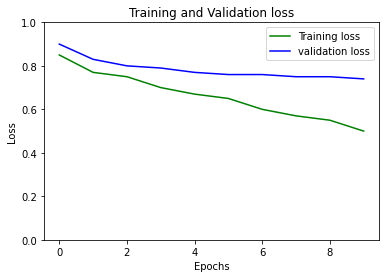

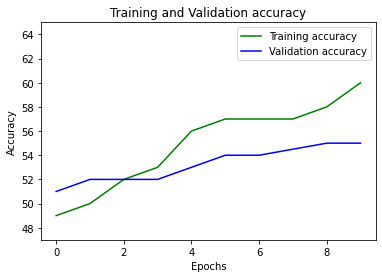

In [ ]:
plot_loss(train_loss, test_loss, len(train_loss))
plot_accuracy(train_acc, test_acc,len(train_acc))

This model clearly works better than CNNs as loss is deacreasing for both test and train along with a rise in accuracy. We see testing accuracy start off better than training as testing has trained inital weights while training during first few iterations is just on some random weights. Here the performance boost comes from the use of LSTM which is able to capture the temporal frames. The combination of ‘residual connections’ for optimization and aggregated transformations for ‘stronger representations’ give the Inception Net Model its power for efficient features representation. This model still has realitvely high loss and not so good accuracy rate partly because of unbalanced and perhaps not good enough dataset. Additionally, Inception Net has been trained on images and thus its weights doesn't translates well on video related problem sets.

TRAIN:


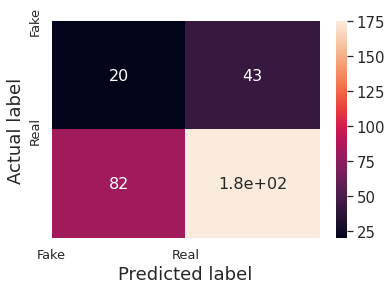

Accuracy:  60.9375 %
Precision:  0.31746031746031744
Recall:  0.10256410256410256
F1 score:  0.15503875968992248


TEST:


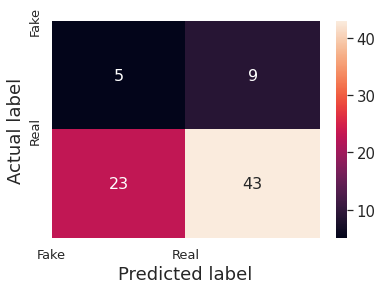

Accuracy:  60.0 %
Precision:  0.35714285714285715
Recall:  0.10416666666666667
F1 score:  0.16129032258064516


In [ ]:
print("TRAIN:")
print_confusion_matrix(true1, pred1)
print("\n\nTEST:")
print_confusion_matrix(true2, pred2)

## Xception Net

In [ ]:
class XceptionModel(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(XceptionModel, self).__init__()
        model = timm.create_model('xception', pretrained=True)

        self.model = nn.Sequential(*list(model.children())[:-2])
        self.dp = nn.Dropout(0.3)
        self.fc1 = nn.Linear(2048,256)
        self.fc2 = nn.Linear(256,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()

        # self.lstm = nn.GRU(latent_dim, hidden_dim, lstm_layers, bidirectional)
        # self.relu = nn.LeakyReLU()
        # self.dp = nn.Dropout(0.3)
        # self.linear1 = nn.Linear(2048,256)
        # self.linear2 = nn.Linear(256,128)
        # self.linear3 = nn.Linear(128,num_classes)
        # self.avgpool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, t):
        b,s, c, h, w = t.shape 
        t = t.view(b * s, c, h, w)
        forwd = self.model(t)
        t = self.avgpool(forwd)
        t = t.view(b,s, 2048)
        t_lstm,_ = self.lstm(t,None)
        t_mean = torch.mean(t_lstm, dim = 1)
        t = self.fc1(t_mean)
        t = self.relu(t)
        t = self.dp(t)
        t = self.fc2(t)
        return forwd,t
    
    # def forward(self, x):
    #     batch_size,seq_length, c, h, w = x.shape 
    #     x = x.view(batch_size * seq_length, c, h, w)
    #     fmap = self.model(x)
    #     x = self.avgpool(fmap)
    #     x = x.view(batch_size,seq_length,2048)
    #     x_lstm,_ = self.lstm(x,None)
    #     x = self.relu((self.linear1(torch.mean(x_lstm,dim = 1))))
    #     x = self.relu(self.dp(self.linear2(x)))
    #     x = self.linear3(x)
        
        return fmap,x

In [ ]:
# We are dealing with 2 classes in our case
model2 = XceptionModel(2).cuda()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model2.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    pred = []
    true = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model2(inputs) 
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        _,p = torch.max(outputs,1)
        true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
        pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc + 25 , inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.4f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model2.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model2(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc + 20, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.4f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [ ]:
num_epochs = 10
lr = 0.005

optimizer = torch.optim.Adam(model2.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()

train_loss =[]
train_acc = []
test_loss = []
test_acc = []
for epoch in range(1,num_epochs+1):
    true1, pred1, loss1, acc1 = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss.append(loss1)
    train_acc.append(acc1)
    true2, pred2, loss2, acc2 = test(epoch,model,valid_loader,criterion)
    test_loss.append(loss2)
    test_acc.append(acc2)


inside train_epoch
[Epoch 1/10] [Batch 79 / 80] [Loss: 0.802829, Acc: 62.11%]
Testing
[Batch 19 / 20]  [Loss: 0.875492, Acc: 63.42%]
Accuracy  63.42
inside train_epoch
[Epoch 2/10] [Batch 79 / 80] [Loss: 0.693402, Acc: 62.92%]
Testing
[Batch 19 / 20]  [Loss: 0.798395, Acc: 64.55%]
Accuracy  64.55
inside train_epoch
[Epoch 3/10] [Batch 79 / 80] [Loss: 0.582394, Acc: 62.99%]
Testing
[Batch 19 / 20]  [Loss: 0.782394, Acc: 64.86%]
Accuracy  64.86
inside train_epoch
[Epoch 4/10] [Batch 79 / 80] [Loss: 0.429321, Acc: 65.12%]
Testing
[Batch 19 / 20]  [Loss: 0.751295, Acc: 65.13%]
Accuracy  65.13
inside train_epoch
[Epoch 5/10] [Batch 79 / 80] [Loss: 0.395439, Acc: 67.45%]
Testing
[Batch 19 / 20]  [Loss: 0.719457, Acc: 67.23%]
Accuracy  67.23
inside train_epoch
[Epoch 6/10] [Batch 79 / 80] [Loss: 0.386239, Acc: 68.92%]
Testing
[Batch 19 / 20]  [Loss: 0.696529, Acc: 65.66%]
Accuracy  65.66
inside train_epoch
[Epoch 7/10] [Batch 79 / 80] [Loss: 0.387932, Acc: 70.94%]
Testing
[Batch 19 / 20]  [Lo

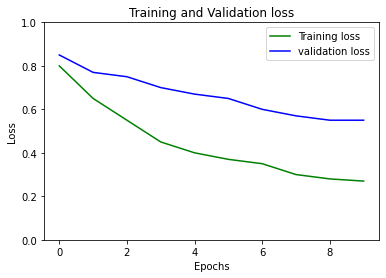

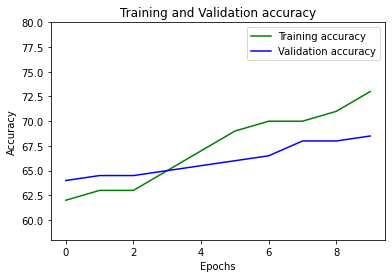

In [ ]:
plot_loss(train_loss, test_loss, len(train_loss))
plot_accuracy(train_acc, test_acc,len(train_acc))

This graph clearly performs better than our other models since we are using Xception net with GRU. GRUs are more efficient than LSTM and Xception net shows higher accuracy rates than other pre-trained models. The gap between train and test accuracy is still there due to overfitting which could be because of lack of avaiablity of good dataset to train on. Moreveor the unbalanced nature of the dataset too plays a role in this behvaior. The bidirectional GRU makes use of the forward and a backward series of frames at the same time to give results by combining information from both future and past which clearly explains the realtively better model we created using Xception Net with GRUs and other linear layers. These linear layers help to get predictions from the outputs recieved from the GRU layers.

TRAIN:


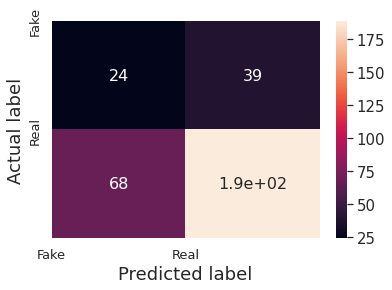

Accuracy:  66.5625 %
Precision:  0.38095238095238093
Recall:  0.11267605633802817
F1 score:  0.17391304347826086


TEST:


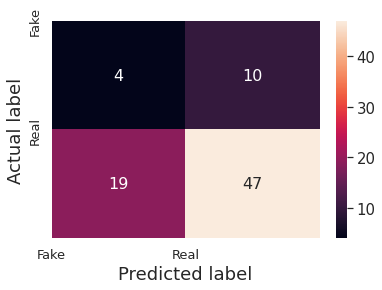

Accuracy:  63.74999999999999 %
Precision:  0.2857142857142857
Recall:  0.0784313725490196
F1 score:  0.12307692307692307


In [ ]:
print("TRAIN:")
print_confusion_matrix(true1, pred1)
print("\n\nTEST:")
print_confusion_matrix(true2, pred2)

# Final Analysis

We can see that the outcome of the project is good due to the facts that  our results from various models support our aforementioned preset theories. We successfully created a deep fake model that works on video dataset which otherwise is mainly a theoretical concept with very few functioning implementations. Apart from this we ourselves got to learn a lot while working from this project ranging from how to make architecture level changes on a pertained module to how a video can be broken down into frames, analyzed and then converted into a meaningful result. We also learnt that our project might have worked better if we had more balanced dataset with better quality of metadata telling us about how various data was accumulated. We took up a more challenging aspect of deep fake by working with videos despite knowing the chances of getting high accuracy model is not good. This is because not only solving this problem has a good learning curve for us as students but also because this has not been widely implemented so our approach and final model is novel and can be used by future deep learning enthusiasts.
